In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import Row
import pyarrow.parquet as pq
import pyarrow as pae
import seaborn as sns

os.environ['SPARK_HOME'] = "/home/veselovs/spark-3.2.1-bin-hadoop2.7"
os.environ['JAVA_HOME'] = "/home/veselovs/jdk-13.0.2"
spark = SparkSession.builder.getOrCreate()

from settings import DATA_DIR, EMBEDDING_DIR

import matplotlib.patheffects as path_effects

import warnings
warnings.filterwarnings('ignore')



22/06/25 18:10:35 WARN Utils: Your hostname, iccluster039 resolves to a loopback address: 127.0.1.1; using 10.90.38.15 instead (on interface ens786f0)
22/06/25 18:10:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/25 18:10:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import matplotlib as mpl
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [46]:
en_shares = pd.read_parquet("data/all_wikilinks_clean.parquet")
wikidbs = ["en","de","fr","ja","es","ru","pl","it", "pt", "nl","sv","vi"]

In [111]:
curlie_data = spark.read.csv("data/curlie.csv", encoding = "utf-8", header = True)

In [98]:
# number shares
# here we are getting the scores to make the columns of the table
en_shares2 = en_shares[en_shares["wikidb"].isin(wikidbs)]

num_shares = en_shares2.groupby("wikidb")["title"].count()

num_articles = en_shares2.groupby("wikidb")["title"].nunique()

average_shares_per_article = en_shares2.groupby(["wikidb","title"])["domain"].count().reset_index().groupby("wikidb")["domain"].mean()

In [107]:
average_shares_per_article

wikidb
de     7.130877
en    13.491044
es     7.455647
fr     7.116074
it     7.036881
ja     6.791530
nl     4.318497
pl     4.664878
pt     5.266747
ru     5.813711
sv     5.141466
vi     8.699952
Name: domain, dtype: float64

In [104]:
num_shares.sort_values(ascending=False)

wikidb
en    48829702
de     5882838
fr     4925889
ja     4455828
es     3629491
ru     2705021
it     2463232
pt     1194040
sv     1138989
nl      892750
vi      882410
pl      752888
Name: title, dtype: int64

In [106]:
num_articles.sort_values(ascending=False)

wikidb
en    3619416
de     824981
fr     692220
ja     656086
es     486811
ru     465283
it     350046
pt     226713
sv     221530
nl     206727
pl     161395
vi     101427
Name: title, dtype: int64

In [3]:
# this function calculates what percentage of articles that represent 80% of shares

def calculate_proportion(group):
    f = group.groupby("title")["url"].count().sort_values(ascending=False).reset_index()
    f["cumsum"] = f["url"].cumsum()
    total_sum = f["url"].sum()
    f["proportion"] = f["cumsum"] / total_sum
    f = f.reset_index(drop = True)
    return f[f["proportion"] > .8].iloc[0].name / len(f)
    

In [93]:
groups = en_shares2.groupby("wikidb")

In [94]:
vals = []

for i, group in groups:
    vals.append([i,calculate_proportion(group)])

In [95]:
vals

[['de', 0.16805720374166194],
 ['en', 0.08984184188830463],
 ['es', 0.16985236570250056],
 ['fr', 0.17417584005085088],
 ['it', 0.1560080675111271],
 ['ja', 0.20149645016049725],
 ['nl', 0.28964769962317455],
 ['pl', 0.2275968896186375],
 ['pt', 0.21855385443269684],
 ['ru', 0.189136504020134],
 ['sv', 0.2313682119803187],
 ['vi', 0.12317233083892849]]

In [6]:
# knowledge gap  in terms of sharing

In [47]:
import urllib

@F.udf
def normalise_title(title):
    """ Replace _ with space, remove anchor, capitalize """
    title = str(title)
    title = urllib.parse.unquote(title)
    title = title.strip()
    if len(title) > 0:
        title = title[0].upper() + title[1:]
    n_title = title.replace("_", " ")
    # if '#' in n_title:
    #     n_title = n_title.split('#')[0]
    return n_title

In [48]:
# import wikilinks

wiki_group = spark.read.load(DATA_DIR+ "/all_wikilinks_grouped.parquet")

# import views
views = spark.read.load(DATA_DIR + "/page_views/2021-02/all_views.parquet")

views = views.cache()

22/06/25 20:23:07 WARN CacheManager: Asked to cache already cached data.


In [15]:
# import curlie data to capture which sites use Wikipedia vs. which sites

curlie_data = pd.read_csv("data/curlie.csv", encoding = "utf-8").drop("Unnamed: 0",axis = 1).rename({"url":"domain"},axis = 1).drop_duplicates(subset="domain")

In [17]:
a = wiki_group.toPandas()

In [18]:
curlie_data.columns

Index(['domain', 'uid', 'label', 'lang'], dtype='object')

In [27]:
curlie_data["domain"] = curlie_data["domain"].apply(lambda x: ".".join(x.split(".")[1:]) if "www." in x else x)

In [44]:
curlie_data[curlie_data["domain"] == "wordpress.com"]["label"]

1340200    /en/Computers/Internet/On_the_Web/Weblogs/Host...
Name: label, dtype: object

In [19]:
a.columns

Index(['wikidb', 'title', 'domain', 'count'], dtype='object')

In [29]:
b = a.merge(curlie_data)

In [30]:
b["domain"].nunique()

110932

In [129]:
curlie_topics = pd.read_csv("/scratch/venia/web2wiki/data/curlie_topic_counts.csv")

In [35]:
wiki_topic_counts = pd.read_parquet("/scratch/venia/web2wiki/url_wiki_topics.parquet")

In [36]:
topic_counts = wiki_topic_counts.groupby("topic_url")["domain"].count()

In [141]:
topic_counts = topic_counts.reset_index()
topic_counts.columns = ["label_leaf", "wiki_count"]

In [303]:
def calculate_z_score(dff, col: int):
    df = dff.copy()
    mean = df[col].mean()
    std = df[col].std()
    df["z_" + col] = (df[col] - mean) / std
    return df

In [480]:
db_views = views.groupby("wikidb").sum("views")

In [5]:
dbs = ["en","de","fr","ja","es","ru","it","pt","sv","nl","vi","pl"]

In [4]:
db_views = views.filter(F.col("wikidb") == "en")

In [9]:
total_views.columns

Index(['wikidb', 'title', 'views'], dtype='object')

In [6]:
total_views = db_views.toPandas()

In [8]:
groups = total_views.groupby("wikidb")

In [13]:
# this function calculates what percentage of articles that represent 80% of shares

def calculate_proportion2(group):
    f = group.groupby("title")["views"].sum().sort_values(ascending=False).reset_index()
    f["cumsum"] = f["views"].cumsum()
    total_sum = f["views"].sum()
    f["proportion"] = f["cumsum"] / total_sum
    f = f.reset_index(drop = True)
    return f[f["proportion"] > .8].iloc[0].name / len(f)
    

In [14]:
calculate_proportion2(total_views)

0.03361815557312585

In [38]:
topic_counts = calculate_z_score_log(topic_counts, "wiki_count")
curlie_topics = calculate_z_score_log(curlie_topics, "label_leaf.1")

KeyError: 'wiki_count'

In [152]:
a = topic_counts.merge(curlie_topics)

In [155]:
a["dif"] = a["z_wiki_count"] - a["z_label_leaf.1"]

In [157]:
a = a.sort_values(by = "dif", ascending=False)

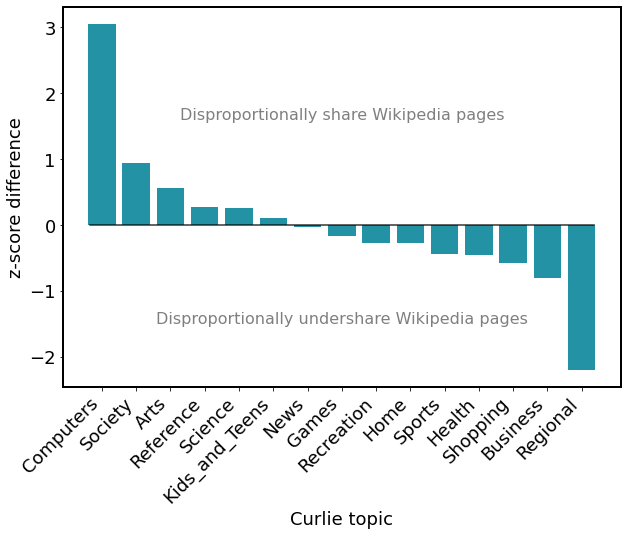

In [210]:
fig,ax=plt.subplots(figsize = (10,7))
ax.bar(a["label_leaf"], a["dif"], color = "#2292A4")
ax.set_xlabel("Curlie topic")
ax.set_ylabel("z-score difference")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.text(7,1.6, "Disproportionally share Wikipedia pages", fontsize = 16, ha ="center", alpha = 0.5)
ax.text(7,-1.5, "Disproportionally undershare Wikipedia pages", fontsize = 16, ha ="center",alpha = 0.5)
ax.axhline(0,0.048,0.952, c = "k", alpha = 0.8)
plt.savefig("visuals/z_score_curlie.pdf",dpi = 300, bbox_inches = "tight")

In [475]:
views = merged.drop_duplicates(subset="title")

In [476]:
views.groupby("wikidb")["views"].sum().sort_values(ascending=False).head(20)

wikidb
en    1534931979
ja     264366472
de     222539825
ru     197392129
es     160655896
fr     142676955
zh      80202155
it      76741983
pl      53222825
pt      43348312
nl      27782565
cs      19193060
ar      16964209
tr      14385825
hu      13588310
sv      13527500
he      13177481
fa      12731911
uk      11508499
el      10229677
Name: views, dtype: int64

In [128]:
import urllib

def process_leaf(x):
    x = urllib.parse.unquote(x)
    return x

def create_english_curlie(curlie_data):
    en_curlie = curlie_data.loc[curlie_data["lang"] == "en"]
    en_curlie["domain"] = en_curlie["domain"].apply(lambda x: x.replace("www.", ""))
    en_curlie["label_leaf"] = en_curlie["label"].apply(lambda x: x.split("/")[-1])
    en_curlie["label"] = en_curlie["label"].apply(lambda x: process_leaf(x))
    return en_curlie

### In case we want to use the Common Crawl

In [6]:
import glob
files = glob.glob(DATA_DIR + "common_crawl_dump/*")

In [118]:
crawl_dump = spark.read.option("delimiter", "\t").csv(DATA_DIR + "common_crawl_dump/cc-main-2020-21-oct-nov-jan-host-ranks.txt.gz", header = True)

crawl_dump2 =spark.read.option("delimiter", "\t").csv(DATA_DIR + "common_crawl_dump/cc-main-2021-feb-apr-may-domain-ranks.txt.gz", header = True)

In [ ]:
# this fn is necessary for reversing the host names
@F.udf 
def reverse_reverse_host(x):
    x = x.split(".")
    x = x[-1::-1]
    x = ".".join(x)
    return x

crawl_dump = crawl_dump.withColumn("host",reverse_reverse_host("#host_rev"))

In [49]:
views = views.orderBy("views",ascending=False).dropDuplicates(subset = ["title", "wikidb"])

wiki_group = wiki_group.filter(F.col("count") < 51)

unique_count = wiki_group.groupBy(["domain"]).agg(F.countDistinct(F.col("count")).alias("nunique")).orderBy("nunique", ascending=False)


In [50]:
views = views.withColumn("title", normalise_title(F.col("title")))

In [51]:
views = views.orderBy("views",ascending=False).dropDuplicates(subset = ["title", "wikidb"])

In [52]:
views = views.dropna(subset = ["title", "wikidb"])
wiki_group = wiki_group.dropna(subset = ["title", "wikidb"])

wiki_group = wiki_group.withColumn("key", F.concat("title",F.lit("_"), "wikidb"))
views = views.withColumn("key", F.concat("title",F.lit("_"), "wikidb"))

Two score we want to capture
1. Which languages are most trusted by the internet. I.e. by taking the ratio of url shares : wiki views we can compare Wikipedia popularity to liklihood of the article being invoked.
2. Which articles are most frequently invoked.

### Part 1: Global differences

In [ ]:
merge = wiki_group.join(views, wiki_group.key == views.key, "inner").drop("key")
merged = merge.toPandas()

In [ ]:
merged = merged.loc[:,~merged.columns.duplicated()]

In [ ]:
merged.to_parquet("data/view_count_pairing.parquet", index = False)

## Import merged here :D, don't forget

In [54]:
merged = pd.read_parquet("data/view_count_pairing.parquet")

In [55]:
db_specific = merged.groupby("wikidb")[["count", "views"]].sum()
db_specific["ratio"] = db_specific["count"] / db_specific["views"]
db_specific = db_specific[db_specific["views"] > 5000000]
db_specific = db_specific.sort_values(by = "ratio", ascending = False).reset_index()

In [56]:
db_subset = db_specific.head(25)

In [61]:
def calculate_z_score(dff, col: int):
    df = dff.copy()
    mean = df[col].mean()
    std = df[col].std()
    df["z_" + col] = (df[col] - mean) / std
    return df

In [347]:
def scatter_plot(df, col1, col2, annotate, figsize = (8,7)):
    x = df[col1]
    y = df[col2]
    text = df[annotate]
        
    fig, ax = plt.subplots(figsize = figsize)
    
    x = np.log(df[col1])
    y = np.log(df[col2])
    m, b = np.polyfit(x, y, 1)
    y_ = m*x + b
    dist = np.abs(y-y_)


    x = np.exp(x)
    y = np.exp(y)
    y_ = np.exp(y_)
            

    ax.plot(x, y_, color = "k", alpha = 0.1)
    ax.scatter(x,y)
    df["dist"] = dist
            
    df["x"] = x
    df["y"] = y
    df["y_"] = y_


    df.sort_values(by = "dist", ascending = True, inplace = True)

    mean_dist = np.mean(df["dist"])



    x = df["x"]
    y = df["y"]
    y_ = df["y_"]
    text = df[annotate]

    ax.scatter(x,y, s = 60,alpha = 0.6)
    ax.plot(x, y_, color = "k", alpha = 0.5)

    df2 = df[(df["dist"]> 1.2*mean_dist) | (df["x"] >= max(df["x"]) / 200.5)]

    x2 = df2["x"]
    y2 = df2["y"]
    y2_ = df2["y_"]
    text2 = df2[annotate]

    mapped = []


    for x_,y_,text_ in zip(x2.values,y2.values,text2):
        t = ax.text(x_, y_, text_, ha = "right")
        t.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w')])
            
    
    ax.set_ylabel("Shares (log)", fontsize = 20)
    ax.set_xlabel("Page views (log)", fontsize =20)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(axis="x", linestyle = "--")
    ax.set_title("Wiki langs with more than 5,000,000 views")
    plt.savefig("visuals/view_share_ratio.jpg", dpi = 300, bbox_inches = "tight")
    plt.show()

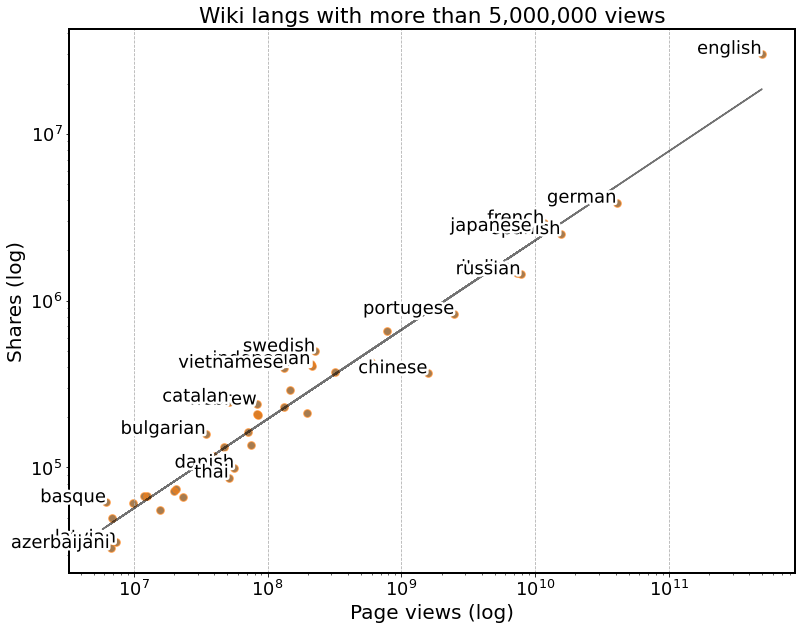

In [348]:
scatter_plot(db_specific2, "views", "count","name", figsize = (13,10))

In [58]:
def convert_db(dbb):
    db = dbb.copy()
    db["log_count"] = db["count"].apply(lambda x: np.log(x))
    db["log_views"] = db["views"].apply(lambda x: np.log(x))
    db = calculate_z_score(db, "log_views")
    db = calculate_z_score(db, "log_count")
    dif_dict = {}
    
    for i, row1 in db[["name", "z_log_views", "z_log_count"]].iterrows():
        dif_dict[row1["name"]] = {}
        n1 = row1["name"]
        v1 = row1["z_log_views"]
        c1 = row1["z_log_count"]
        for j, row2 in db[["name", "z_log_views", "z_log_count"]].iterrows():
            n2 = row2["name"]
            v2 = row2["z_log_views"]
            c2 = row2["z_log_count"]
            if n1 != n2:
                dif_dict[n1][n2] = np.abs(c1 - c2) / np.abs(v1 - v2)
            else:
                dif_dict[n1][n2] = 1
    
    dif_df = pd.DataFrame.from_dict(dif_dict)
    return dif_df 
    

In [59]:
langs = pd.read_csv("data/wiki_name.csv")
db_specific2 = db_specific.merge(langs, on = "wikidb")

In [62]:
dif_df = convert_db(db_specific2)

In [63]:
dif_melted = dif_df.reset_index().melt(id_vars = "index").sort_values(by = "index", ascending = False)
#dif_melted = dif_melted.drop_duplicates(subset = "value")



In [64]:
dif_melted.columns = ["wikidb1","wikidb2", "z-score-dif"]

In [65]:
dif_melted.sort_values(by = "z-score-dif",ascending=False).drop_duplicates(subset=["z-score-dif"]).to_html("/home/veselovs/html/z_score_dif.html")


In [355]:
en__ = dif_melted[dif_melted["wikidb1"] == "english"].sort_values(by = "z-score-dif",ascending=False)

In [175]:
en__.to_html("/home/veselovs/html/z_score_dif_english_to_wikidb.html")

### Part (2): Local structure
First we'll limit our analysis to English.

In [357]:
en = merged[merged["wikidb"] == "en"]
en.sort_values(by = "count", inplace = True, ascending = False)
en_g = en.groupby(["title"]).agg({"count": "sum", "views":"sum"})



In [ ]:
def present_domains(term):
    return merged[merged["title"] == term].groupby("domain")["count"].sum().sort_values(ascending = False)

en_g = en_g[(en_g["count"] > 9) & (en_g["views"] > 300)]


In [358]:
en_g["ratio"] = en_g["count"] / en_g["views"]

In [447]:
# number of domains that share that article
# top domain that shares that article (plus number of shares)
# # number wiki related domains

In [364]:
en.columns

Index(['wikidb', 'title', 'domain', 'count', 'views'], dtype='object')

In [365]:
en = en.sort_values(by = "count",ascending=False)
en = en[en["title"] != ""]
top1 = en.groupby("title")[["title","domain","count"]].head(1)
n_unique = en.groupby("title")["domain"].nunique().reset_index()

n_unique = n_unique[n_unique["title"].str.len() > 0]
n_unique.columns = ["title", "nunique"]

meta = n_unique.merge(top1, on = ["title"])

In [366]:
en_g2 = en_g.merge(meta, on = ["title"])

In [367]:
en_g2 = en_g2.rename({"count_y": "domain_count","count_x": "title_count"}, axis = 1)

In [368]:
en_g2.sort_values(by = "ratio",ascending=False, inplace = True)

In [518]:
en_g2.to_csv("data/views_shares/en/view_shares.csv", index = False)

### Connecting to ORES

In [67]:
ores = pd.read_csv("/scratch/venia/wiki_embedding_project/data/qid_topic_quality.csv.gz")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:662)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:628)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:604)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:561)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:518)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [68]:
pid_title = pd.read_parquet("/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/en/identifiers.parquet")

pid_title = pid_title[["page_id", "page_title"]]
pid_title.columns = ["page_id","title"]

In [69]:
ores = ores.rename({"wiki_db":"wikidb"}, axis = 1)

In [70]:
ores["wikidb"]=ores["wikidb"].apply(lambda x: x[:-4])
en_ores = ores[ores["wikidb"] == "en"]
en_ores = en_ores[["wikidb", "qid","topic"]]

In [71]:
ores["topic2"] = ores["topic"].apply(lambda x: x.split(".")[1])

In [72]:
count = ores.groupby("topic2")["qid"].count().reset_index()

In [75]:
# topic_counts = topic_counts.rename({"topic_leaf":"topic2"}, axis = 1)

In [ ]:
topic_counts.column=["topic2", "ores_count"]
count.columns = ["topic2", "wiki_count"]

In [ ]:
topic_counts = topic_counts.reset_index()

In [ ]:
topic_counts = calculate_z_score_log(topic_counts, "domain")
count = calculate_z_score_log(count, "wiki_count")

In [ ]:
dif = count.merge(topic_counts)

In [ ]:
dif["dif"] = dif["z_wiki_count"] - dif["z_domain"]

In [ ]:
dif = dif.sort_values(by ="dif",ascending=False)

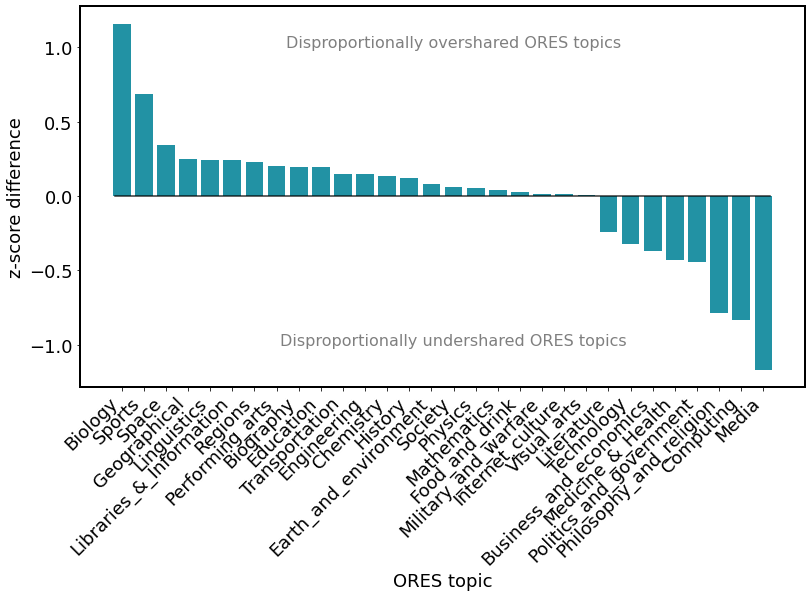

In [281]:
fig,ax=plt.subplots(figsize = (13,7))
ax.bar(dif["topic2"],dif["dif"], color = "#2292A4")
ax.set_xlabel("ORES topic")
ax.set_ylabel("z-score difference")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.text(15,1, "Disproportionally overshared ORES topics", fontsize = 16, ha ="center", alpha = 0.5)
ax.text(15,-1, "Disproportionally undershared ORES topics", fontsize = 16, ha ="center",alpha = 0.5)
ax.axhline(0,0.048,0.952, c = "k", alpha = 0.8)
plt.savefig("visuals/z_score_ores.pdf",dpi = 300, bbox_inches = "tight")

In [77]:
import glob
identifiers = glob.glob("/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/*/identifiers.parquet")

In [78]:
identifiers[0].split("/")[-2]

'en'

In [79]:
all_identifiers = spark.read.load(identifiers[0])
all_identifiers.createOrReplaceTempView("all_identifiers")

all_identifiers = spark.sql("select *, 'en' as wikidb from all_identifiers")

for iden in identifiers[1:]:
    
    print(iden)
    temp_iden = spark.read.load(iden)
    temp_iden.createOrReplaceTempView("temp_iden")
    temp_iden = spark.sql("select *, '{}' as wikidb from temp_iden".format(iden.split("/")[-2]))

    all_identifiers = all_identifiers.union(temp_iden)


    

/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/ru/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/ja/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/de/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/fr/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/it/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/pl/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/fa/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/zh/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/es/identifiers.parquet
/dlabdata1/wiki_embedding_project/Data/preprocessing/matchings/page_identifers/pt/

In [80]:
all_id = all_identifiers.toPandas()

In [81]:
all_id = all_id.rename({"page_title": "title"},axis=1)

In [82]:
merged_metadata = merged.merge(all_id, on = ["wikidb", "title"], how = "inner")

In [84]:
merged_metadata.to_parquet("/scratch/venia/web2wiki/data/merged_metadata.parquet", index = False)

In [ ]:
merged_metadata = pd.read_parquet("/scratch/venia/web2wiki/data/merged_metadata.parquet")

In [644]:

print(f"We have topic metadata for {len(merged_metadata) / len(merged):.2f}% of the wiki pages.")

We have topic metadata for 0.72% of the wiki pages.


The motivating question for this part, is do different languages care about different topics? Can do something with z-scores and proportion of invocations that relate to that topic. I.e.
1. Merge ORES and merge dataframes above.
2. Groupby \[wikidb, topic\] and take sum of counts.
3. Calculate z-score between mean over everything, and each db. 
4. Plot everything

1.

In [85]:
merged_metadata = merged_metadata.rename({"Qid":"qid"},axis = 1)

In [86]:
merged_metadata.columns

Index(['wikidb', 'title', 'domain', 'count', 'views', 'page_id', 'qid'], dtype='object')

In [87]:
o_m = merged_metadata.merge(ores[["wikidb","qid","topic", "pred_qual"]], on = ["wikidb", "qid"])

In [88]:
o_m["topic_leaf"] = o_m["topic"].apply(lambda x: x.split(".")[-1])

In [89]:
topic_counts = o_m.groupby("topic_leaf")["domain"].count()

In [90]:
o_m.to_parquet("/scratch/venia/web2wiki/data/o_m.parquet", index = False)

In [93]:
bias_scores = pd.read_csv("/scratch/venia/web2wiki/data/bias_scores.csv")

In [95]:
o_m = o_m.merge(bias_scores[["domain","score"]], how = "left")

In [96]:
o_m

,wikidb,title,domain,count,views,page_id,qid,topic,pred_qual,topic_leaf,score
0,en,"""E"" Is for Evidence",freebooknotes.com,2,80,16251903,Q4540279,Culture.Literature,0.405515,Literature,NaN
1,en,"""E"" Is for Evidence",blogspot.com,2,80,16251903,Q4540279,Culture.Literature,0.405515,Literature,NaN
2,ja,&TWICE,musiclauncher.jp,1,264,4001788,Q67514684,Culture.Media.Music,0.422830,Music,NaN
3,en,'Till I Collapse,pungenerator.org,2,2316,25048455,Q28004,Culture.Media.Music,0.452087,Music,NaN
4,fr,(10) Hygie,wikibis.com,2,125,105846,Q2640,STEM.Space,0.791429,Space,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20504732,ja,齋藤恵美子,yuumei.info,1,26,1294075,Q11679105,Culture.Media.Films,0.291166,Films,NaN
20504733,ja,齋藤陽道,name-power.net,1,233,4134930,Q94187325,Geography.Regions.Asia.East_Asia,0.524121,East_Asia,NaN
20504734,zh,齿合度,appspot.com,1,68,990988,Q3023362,STEM.Chemistry,0.367821,Chemistry,NaN
20504735,zh,龍虎風雲,mandyvincent.com,3,562,434955,Q867713,Culture.Media.Films,0.560363,Films,NaN


In [375]:
en_m = o_m[o_m["wikidb"] == "en"]



In [394]:
en_m.to_parquet("data/en_shares_merged.parquet", index=False)

In [248]:
quartiles = pd.qcut(en_m.groupby("topic_leaf")["views"].transform("sum"), 5,labels = False)

In [249]:
en_m["quartile"] = quartiles

/tmp/ipykernel_14845/554005529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_m["quartile"] = quartiles


In [250]:
en_m_g = en_m.groupby(["topic_leaf"])[["count","views","quartile"]].mean().reset_index()
en_m_g["ratio"] = en_m_g["count"] / en_m_g["views"]
en_m_g.sort_values(by = "ratio", inplace=True, ascending=True)
en_m_g["rank"] =en_m_g.groupby(["quartile"])["ratio"].transform("rank", ascending = False)
en_m_g.sort_values(by = "rank",inplace=True)

In [252]:
en_m_g.sort_values(by = "rank",ascending=True).to_html("~/html/topic_ratios.html")

In [414]:
o_m

,wikidb,title,domain,count,views,page_id,qid,topic,pred_qual,topic_leaf
0,en,"""E"" Is for Evidence",freebooknotes.com,2,80,16251903,Q4540279,Culture.Literature,0.405515,Literature
1,en,"""E"" Is for Evidence",blogspot.com,2,80,16251903,Q4540279,Culture.Literature,0.405515,Literature
2,ja,&TWICE,musiclauncher.jp,1,264,4001788,Q67514684,Culture.Media.Music,0.422830,Media
3,en,'Till I Collapse,pungenerator.org,2,2316,25048455,Q28004,Culture.Media.Music,0.452087,Media
4,fr,(10) Hygie,wikibis.com,2,125,105846,Q2640,STEM.Space,0.791429,Space
...,...,...,...,...,...,...,...,...,...,...
20504732,ja,齋藤恵美子,yuumei.info,1,26,1294075,Q11679105,Culture.Media.Films,0.291166,Media
20504733,ja,齋藤陽道,name-power.net,1,233,4134930,Q94187325,Geography.Regions.Asia.East_Asia,0.524121,Regions
20504734,zh,齿合度,appspot.com,1,68,990988,Q3023362,STEM.Chemistry,0.367821,Chemistry
20504735,zh,龍虎風雲,mandyvincent.com,3,562,434955,Q867713,Culture.Media.Films,0.560363,Media


2.

In [136]:
o_m_g = o_m.groupby(["wikidb","topic_leaf"])["count"].sum().reset_index()

In [137]:
vals =  o_m_g.groupby("wikidb")["count"].transform("sum")
o_m_g["total_count"] = vals

In [138]:
o_m_g.columns = ['wikidb', 'topic_leaf', 'count', 'total_count']

In [139]:
o_m_g["proportion"] = o_m_g["count"] / o_m_g["total_count"]
std_mean = o_m_g.groupby("topic_leaf")["proportion"].agg(["mean","std"]).reset_index()

3.

In [140]:

o_m_g = o_m_g.merge(std_mean, on = "topic_leaf")


In [141]:
o_m_g

,wikidb,topic_leaf,count,total_count,proportion,mean,std
0,de,Architecture,32638,3488858,0.009355,0.007603,0.001706
1,en,Architecture,204229,25457460,0.008022,0.007603,0.001706
2,es,Architecture,20228,2154044,0.009391,0.007603,0.001706
3,fa,Architecture,2486,245757,0.010116,0.007603,0.001706
4,fr,Architecture,18172,2439518,0.007449,0.007603,0.001706
...,...,...,...,...,...,...,...
622,ja,Women,16456,2347087,0.007011,0.006156,0.001758
623,pl,Women,1486,396392,0.003749,0.006156,0.001758
624,pt,Women,3588,697202,0.005146,0.006156,0.001758
625,ru,Women,6795,1216233,0.005587,0.006156,0.001758


In [142]:
o_m_g["z_score"] = (o_m_g["proportion"] - o_m_g["mean"]) / o_m_g["std"]

In [143]:
wikidbs = o_m_g["wikidb"].unique()

4.


In [461]:

import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=o_m_g["topic_leaf"],
                                y=o_m_g["z_score"],
                                mode='markers',
                                text=o_m_g['wikidb'])) # hover text goes here

fig.update_layout(title='Z-score between proportion of articles invoked',    xaxis=dict(
        title='Topic leaf',
        tickmode='linear'),
        yaxis = dict(title = "z-score"))
# fig.write_html("/home/veselovs/html/file.html")
fig.show()


#fig, ax = plt.subplots(figsize = (22,12))

#ax.scatter(x = o_m_g["topic_leaf"], y = o_m_g["z_score"])
#ax.tick_params("x", rotation = 70)

I will plot ORES views-shares

In [440]:
db_topic_view_counts = o_m.groupby(["wikidb", "topic_leaf"])[["views", "count"]].sum().reset_index()

In [441]:
langlist = db_topic_view_counts["wikidb"].unique()

In [442]:
datas = {}

for lang in langlist:
    temp = db_topic_view_counts[db_topic_view_counts["wikidb"] == lang].sort_values(by = "views")
    temp["ratio"] = temp["count"] / temp["views"]
    temp.sort_values(by = "ratio", ascending=False, inplace = True)
    datas[lang] = temp

In [443]:
datas["ru"].sort_values(by = "views")

,wikidb,topic_leaf,views,count,ratio
552,ru,Radio,483593,541,0.001119
554,ru,Software,498488,565,0.001133
517,ru,Central_Africa,521253,362,0.000694
567,ru,Western_Africa,1101718,777,0.000705
558,ru,Southern_Africa,1144831,615,0.000537
530,ru,Fashion,1905602,2320,0.001217
515,ru,Books,2686869,1904,0.000709
525,ru,Eastern_Africa,2885328,1242,0.000430
536,ru,Libraries_&_Information,2955718,952,0.000322
527,ru,Education,3537391,2609,0.000738


In [452]:
def scatter_plot2(df_dict, col1, col2, annotate, figsize = (26,24)):
    
    fig, axs = plt.subplots(4,3,figsize = figsize)
    for i, ax in enumerate(axs.flatten()):
        if i < 11:
            lang = langlist[i]
            df = datas[lang].copy()
            df = process_df_(df)

            x = np.log(df[col1])
            y = np.log(df[col2])
            
            text = df[annotate]
            m, b = np.polyfit(x, y, 1)
                        
            y_ = m*x + b
            
            dist = np.abs(y-y_)
            
            x = np.exp(x)
            y = np.exp(y)
            y_ = np.exp(y_)
            
            df["dist"] = dist
            
            df["x"] = x
            df["y"] = y
            df["y_"] = y_
            
                        
            df.sort_values(by = "dist", ascending = True, inplace = True)
            
            mean_dist = np.mean(df["dist"])
            
            
            
            x = df["x"]
            y = df["y"]
            y_ = df["y_"]
            text = df[annotate]
            
            ax.scatter(x,y, s = 60,alpha = 0.6)
            ax.plot(x, y_, color = "k", alpha = 0.5)
            
            df2 = df[df["dist"]> 1.4*mean_dist]
            
            x2 = df2["x"]
            y2 = df2["y"]
            y2_ = df2["y_"]
            text2 = df2[annotate]

            mapped = []
            
            for x_,y_,text_ in zip(x2.values[-30:],y2.values[-30:],text2[-30:]):
                mapped.append(text_)
                t = ax.text(x_, y_, text_, rotation = 0, fontsize = 8, ha = "right", va = "bottom", alpha =.8)
                #t.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w')])
            
            df = df.sort_values(by = "views", ascending = False)
            
            # plot the right most value
            temp = df.iloc[0]
            if temp[annotate] not in mapped:
                t = ax.text(temp["x"], temp["y"], temp[annotate], fontsize = 8, ha = "right", va = "bottom")
                #t.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w')])


            #ax.set_ylabel("Shares (log)", fontsize = 12)
            #ax.set_xlabel("Page views (log)", fontsize =12)

            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.grid(axis="x", linestyle = "--")
            ax.set_title("ORES Topics for {}".format(lang))
            #ax.set_title("Wiki langs with more than 5,000,000 views")
        else:
            ax.set_axis_off()
    plt.savefig("visuals/all_wikidb_ores_views2.jpg", dpi = 300, bbox_inches="tight")
    plt.show()

In [453]:
def process_df_(dff):
    df = dff.copy()
    df["ratio"] = (df["count"] / df["views"])
    df["z"] = (df["ratio"] - df["ratio"].mean()) / df["ratio"].std()
    df["z"] = df["z"].abs()
    df.sort_values(by = "z", inplace=True)
    return df

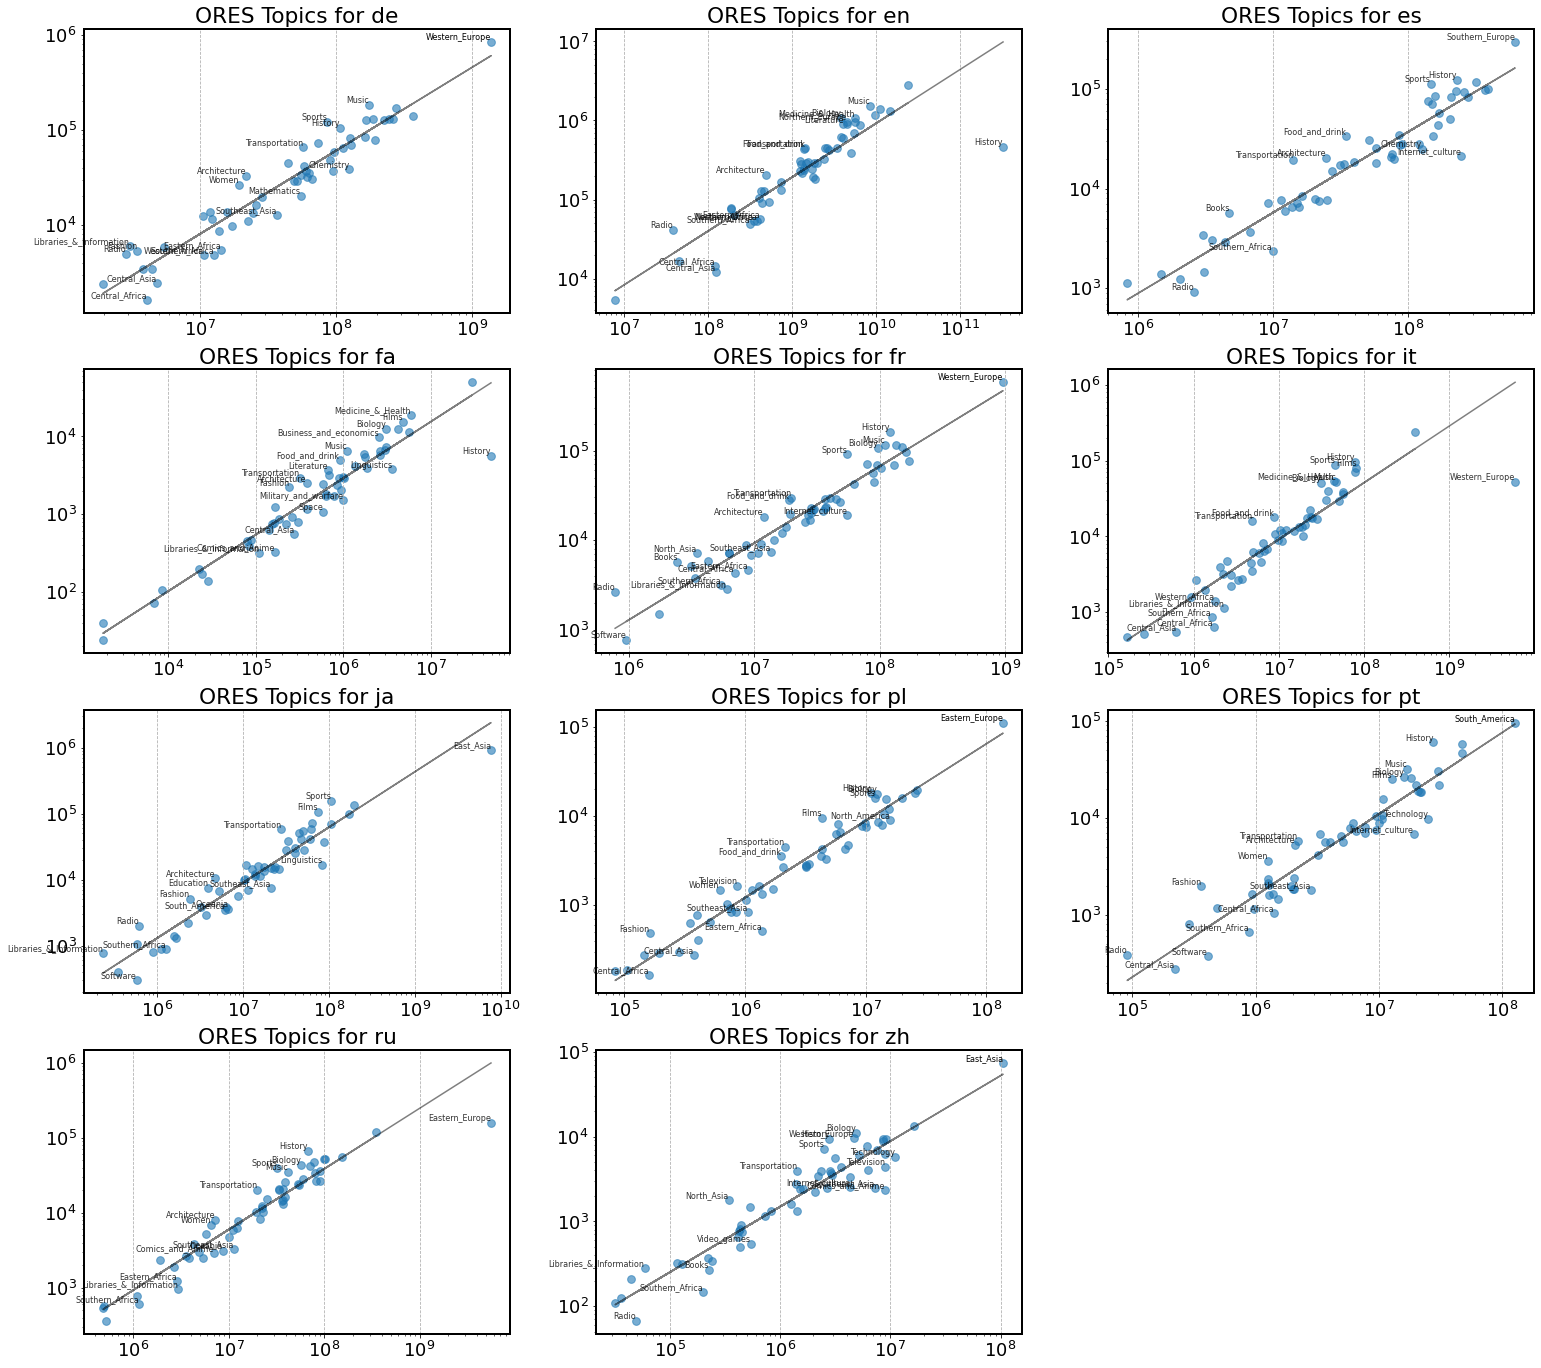

In [454]:
scatter_plot2(datas, "views","count", "topic_leaf")

In [926]:
list_topics = o_m["topic_leaf"].unique()

In [340]:
def topic_analysis(df_restrict, views_limit = 0, count_limits = 0):
    df_restrict = df_restrict.groupby(["topic_leaf","title"])[["count","views"]].sum().reset_index()
    df_restrict = df_restrict[(df_restrict["count"] > count_limits) & (df_restrict["views"]>views_limit)]
    df_restrict["ratio"] = df_restrict["count"] / df_restrict["views"]
    df_restrict = df_restrict.sort_values(by = "ratio")
    df_restrict= df_restrict.groupby("topic_leaf")["ratio"].mean()
    return df_restrict

In [363]:
def topic_analysis2(dff, views_limit = 0, count_limits = 0):
    df = dff.copy()
    df = df.groupby(["wikidb","topic_leaf"])[["count","views"]].sum().reset_index()
    df = df[(df["count"] > count_limits) & (df["views"]>views_limit)]

    x = np.log(df["views"])
    y = np.log(df["count"])

    m, b = np.polyfit(x, y, 1)

    y_ = m*x + b

    dist = y-y_

    x = np.exp(x)
    y = np.exp(y)
    y_ = np.exp(y_)

    df["dist"] = dist

    df["views"] = x
    df["count"] = y
    df["y_"] = y_

    df.sort_values(by = "dist", ascending = True, inplace = True)

    df= df.groupby("topic_leaf")["dist"].agg(["mean", "std"])
    return df

In [341]:
ratios = topic_analysis(o_m)

In [364]:
ratios2 = topic_analysis2(o_m)

In [370]:
ratios2 = ratios2.sort_values(by = "mean",ascending=False).reset_index()

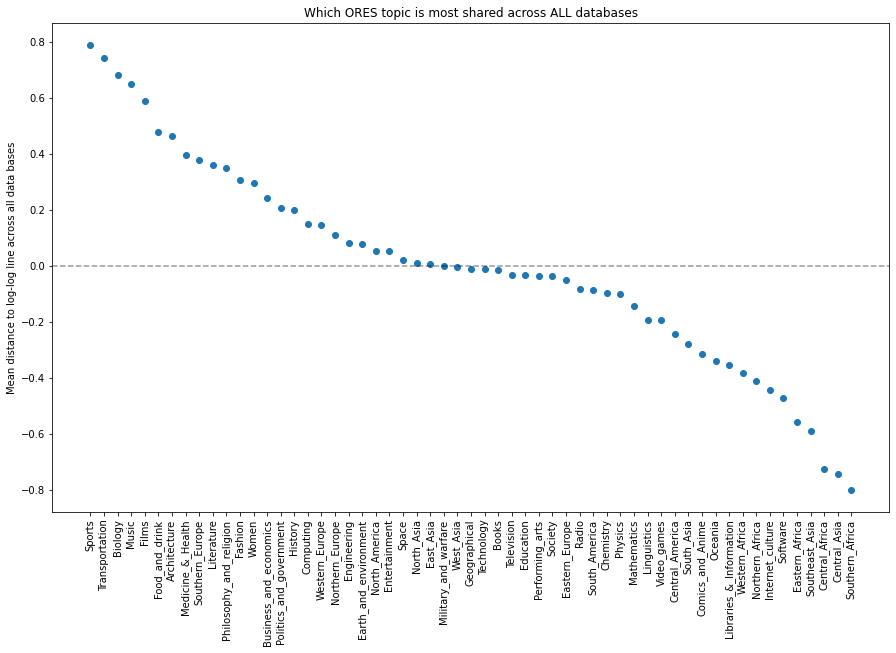

In [384]:
# the average ratio of a topic that comes from shares
fig, ax = plt.subplots(figsize = (15,9))
ax.scatter(ratios2["topic_leaf"], ratios2["mean"])

ax.tick_params("x",rotation = 90)

ax.set_ylabel("Mean distance to log-log line across all data bases")
ax.axhline(0, linestyle = "--", color = "k", alpha = 0.4)
ax.set_title("Which ORES topic is most shared across ALL databases")
plt.savefig("visuals/all_db_topic_distances.jpg", dpi = 300, bbox_inches = "tight")

In [914]:
def showcase_topic(df, topic, views_limit = 0, count_limits = 0):
    df_restrict = df[df["topic_leaf"] == topic]
    df_restrict = df_restrict.groupby(["title"])[["count","views"]].sum().reset_index()
    df_restrict = df_restrict[(df_restrict["count"] > count_limits) & (df_restrict["views"]>views_limit)]
    df_restrict["ratio"] = df_restrict["count"] / df_restrict["views"]
    df_restrict = df_restrict.sort_values(by = "ratio")
    return df_restrict

In [ ]:
for topic in list_topics:
    

In [922]:
na = showcase_topic(o_m, "North_America", 100, 100)

In [920]:
women.to_html("/home/veselovs/html/people_ratios.html", index=False)

bias shit

In [101]:
o_m2 = o_m.dropna(subset=["score"])


In [112]:
o_m2["mean_p"] = o_m2.groupby("topic_leaf")["score"].transform("mean")

o_m2 = o_m2.sort_values(by = "mean_p")

In [128]:
a = o_m2.groupby("domain")["score"].count()

In [129]:
drop = a.sort_values(ascending=False).head(50).index

In [130]:
o_m3 = o_m2[~o_m2["domain"].isin(drop)]

In [134]:
o_m3.domain.nunique()

6237

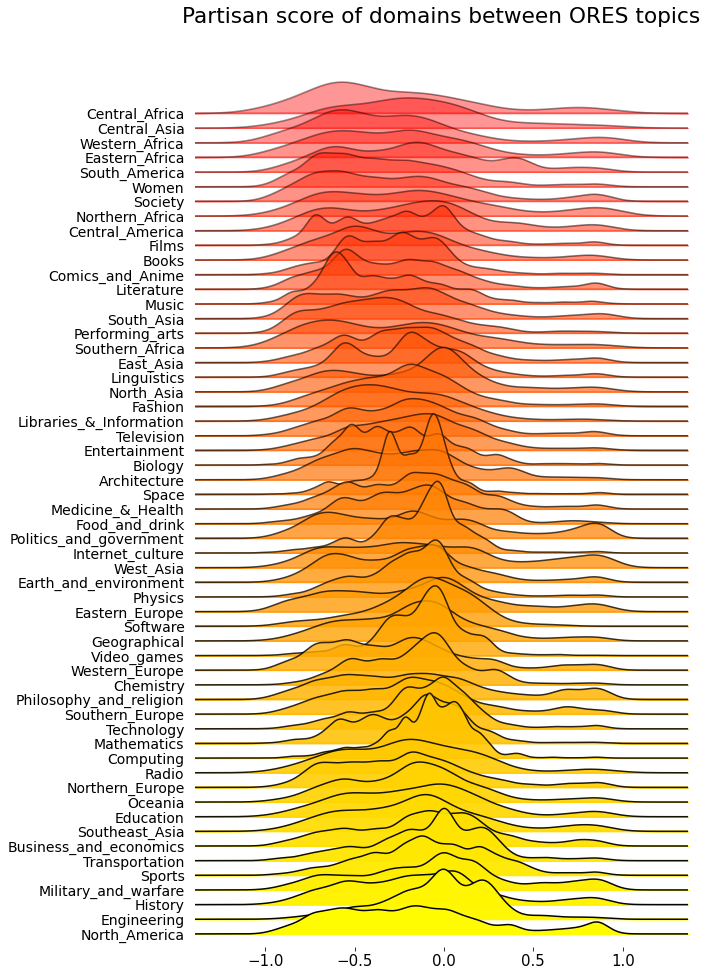

In [135]:
from matplotlib import cm
from joypy import joyplot


fig, ax = plt.subplots(figsize = (10,14))

# a = joyplot(wiki_metadata3,labels = wiki_metadata3["class"].drop_duplicates().values, by = 'mean_p', column = ['pearsonr_scaled',"GS_score_scaled"], colormap=cm.autumn, fade = True,range_style='all', title = "Pearson correlation of behavioural and semantic similarity (top 30 classes by h-index)", xlabelsize = 12, ylabelsize = 11, ax = ax, legend=True)
a = joyplot(o_m3,labels = o_m3["topic_leaf"].drop_duplicates().values,  by = 'mean_p', column = ['score'], colormap=cm.autumn, fade = True,range_style='all', title = "Partisan score of domains between ORES topics", xlabelsize = 15, ylabelsize = 14, ax = ax)


ax.set_xlabel("Partisan score")
plt.savefig("/scratch/venia/web2wiki/visuals/partisan_scores_by_ores_topic.pdf", dpi = 300, bbox_inches="tight")